In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import CLIPProcessor, CLIPModel
from safetensors.torch import load_file
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt

In [30]:
# LightningModule class for the training loop
class CLIPRegressionModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-4):
        super().__init__()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
        self.clip_model.eval()  # Freeze CLIP model weights
        for param in self.clip_model.parameters():
            param.requires_grad = False
        
        self.text_projection = nn.Linear(self.clip_model.config.projection_dim, 512)
        self.image_projection = nn.Linear(self.clip_model.config.projection_dim, 512)
        self.norm_text_layer = nn.LayerNorm(512)
        self.norm_image_layer = nn.LayerNorm(512)
        self.final_layer = nn.Linear(512, 2)
        self.criterion = nn.L1Loss()
        self.learning_rate = learning_rate
    
    def forward(self, text_inputs, image_inputs):
        with torch.no_grad():
            text_features = self.clip_model.get_text_features(**text_inputs)
            image_features = self.clip_model.get_image_features(**image_inputs)
        
        text_proj = self.text_projection(text_features)
        image_proj = self.image_projection(image_features)
        dot_product = self.norm_text_layer(text_proj) * self.norm_image_layer(image_proj)
        output = F.sigmoid(self.final_layer(dot_product))
        
        return output
    
    def training_step(self, batch, batch_idx):
        text_inputs = {key: val.squeeze(1) for key, val in batch.items() if 'input_ids' in key}
        image_inputs = {key: val.squeeze(1) for key, val in batch.items() if 'pixel_values' in key}
        labels = batch['label']
        
        outputs = self(text_inputs, image_inputs)
        loss = self.criterion(outputs, labels)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        text_inputs = {key: val.squeeze(1) for key, val in batch.items() if 'input_ids' in key}
        image_inputs = {key: val.squeeze(1) for key, val in batch.items() if 'pixel_values' in key}
        labels = batch['label']
        
        outputs = self(text_inputs, image_inputs)
        loss = self.criterion(outputs, labels)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

class InferenceModel:
    def __init__(self, model_path, processor):
        self.model = CLIPRegressionModel()
        state_dict = load_file(model_path)
        self.model.load_state_dict(state_dict)
        self.processor = processor
        self.model.eval()
    
    def predict(self, text, image_path):
        image = Image.open(image_path).convert("RGB")
        inputs = self.processor(
            text=[text], 
            images=image, 
            return_tensors="pt", 
            padding="max_length", 
            max_length=self.processor.tokenizer.model_max_length, 
            truncation=True
        )
        text_inputs = {key: val.squeeze(1) for key, val in inputs.items() if 'input_ids' in key}
        image_inputs = {key: val.squeeze(1) for key, val in inputs.items() if 'pixel_values' in key}
        
        with torch.no_grad():
            output = self.model(text_inputs, image_inputs) * 5
        return output.cpu().numpy()


In [31]:
model_path = "agiqa_3k_clip_vitl14.safetensors"
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
inference_model = InferenceModel(model_path, processor)

anime_0
acertain_0.png: [[2.7415628 3.218292 ]]
animagine_xl_31_0.png: [[3.4058619 3.1069589]]
anime_pastel_dream_0.png: [[3.3790283 3.1654496]]
anythingv5_0.png: [[3.012566  3.6626182]]
dall_e_2_0.png: [[2.1210809 3.261117 ]]
dall_e_3_0.png: [[3.360833  3.5311806]]
sd15_0.png: [[2.867229  3.3429801]]
sd21_0.png: [[2.5184588 2.6646912]]
sdxl_0.png: [[3.0913832 3.3322554]]

anime_1
acertain_1.png: [[2.0722845 3.1822042]]
animagine_xl_31_1.png: [[2.4066672 2.7641675]]
anime_pastel_dream_1.png: [[2.5409708 2.7479424]]
anythingv5_1.png: [[2.2938948 3.4444726]]
dall_e_2_1.png: [[1.8723345 3.308709 ]]
dall_e_3_1.png: [[3.2272854 3.3705199]]
sd15_1.png: [[1.7799971 2.3517563]]
sd21_1.png: [[1.9499253 2.0508246]]
sdxl_1.png: [[2.7560458 3.3685875]]

real_0
acertain_0.png: [[2.5408638 3.028812 ]]
animagine_xl_31_0.png: [[1.688205  2.2183414]]
anime_pastel_dream_0.png: [[2.1879017 2.8468614]]
anythingv5_0.png: [[2.1781437 2.3055933]]
dall_e_2_0.png: [[2.882352  2.9403577]]
dall_e_3_0.png: [[2.71

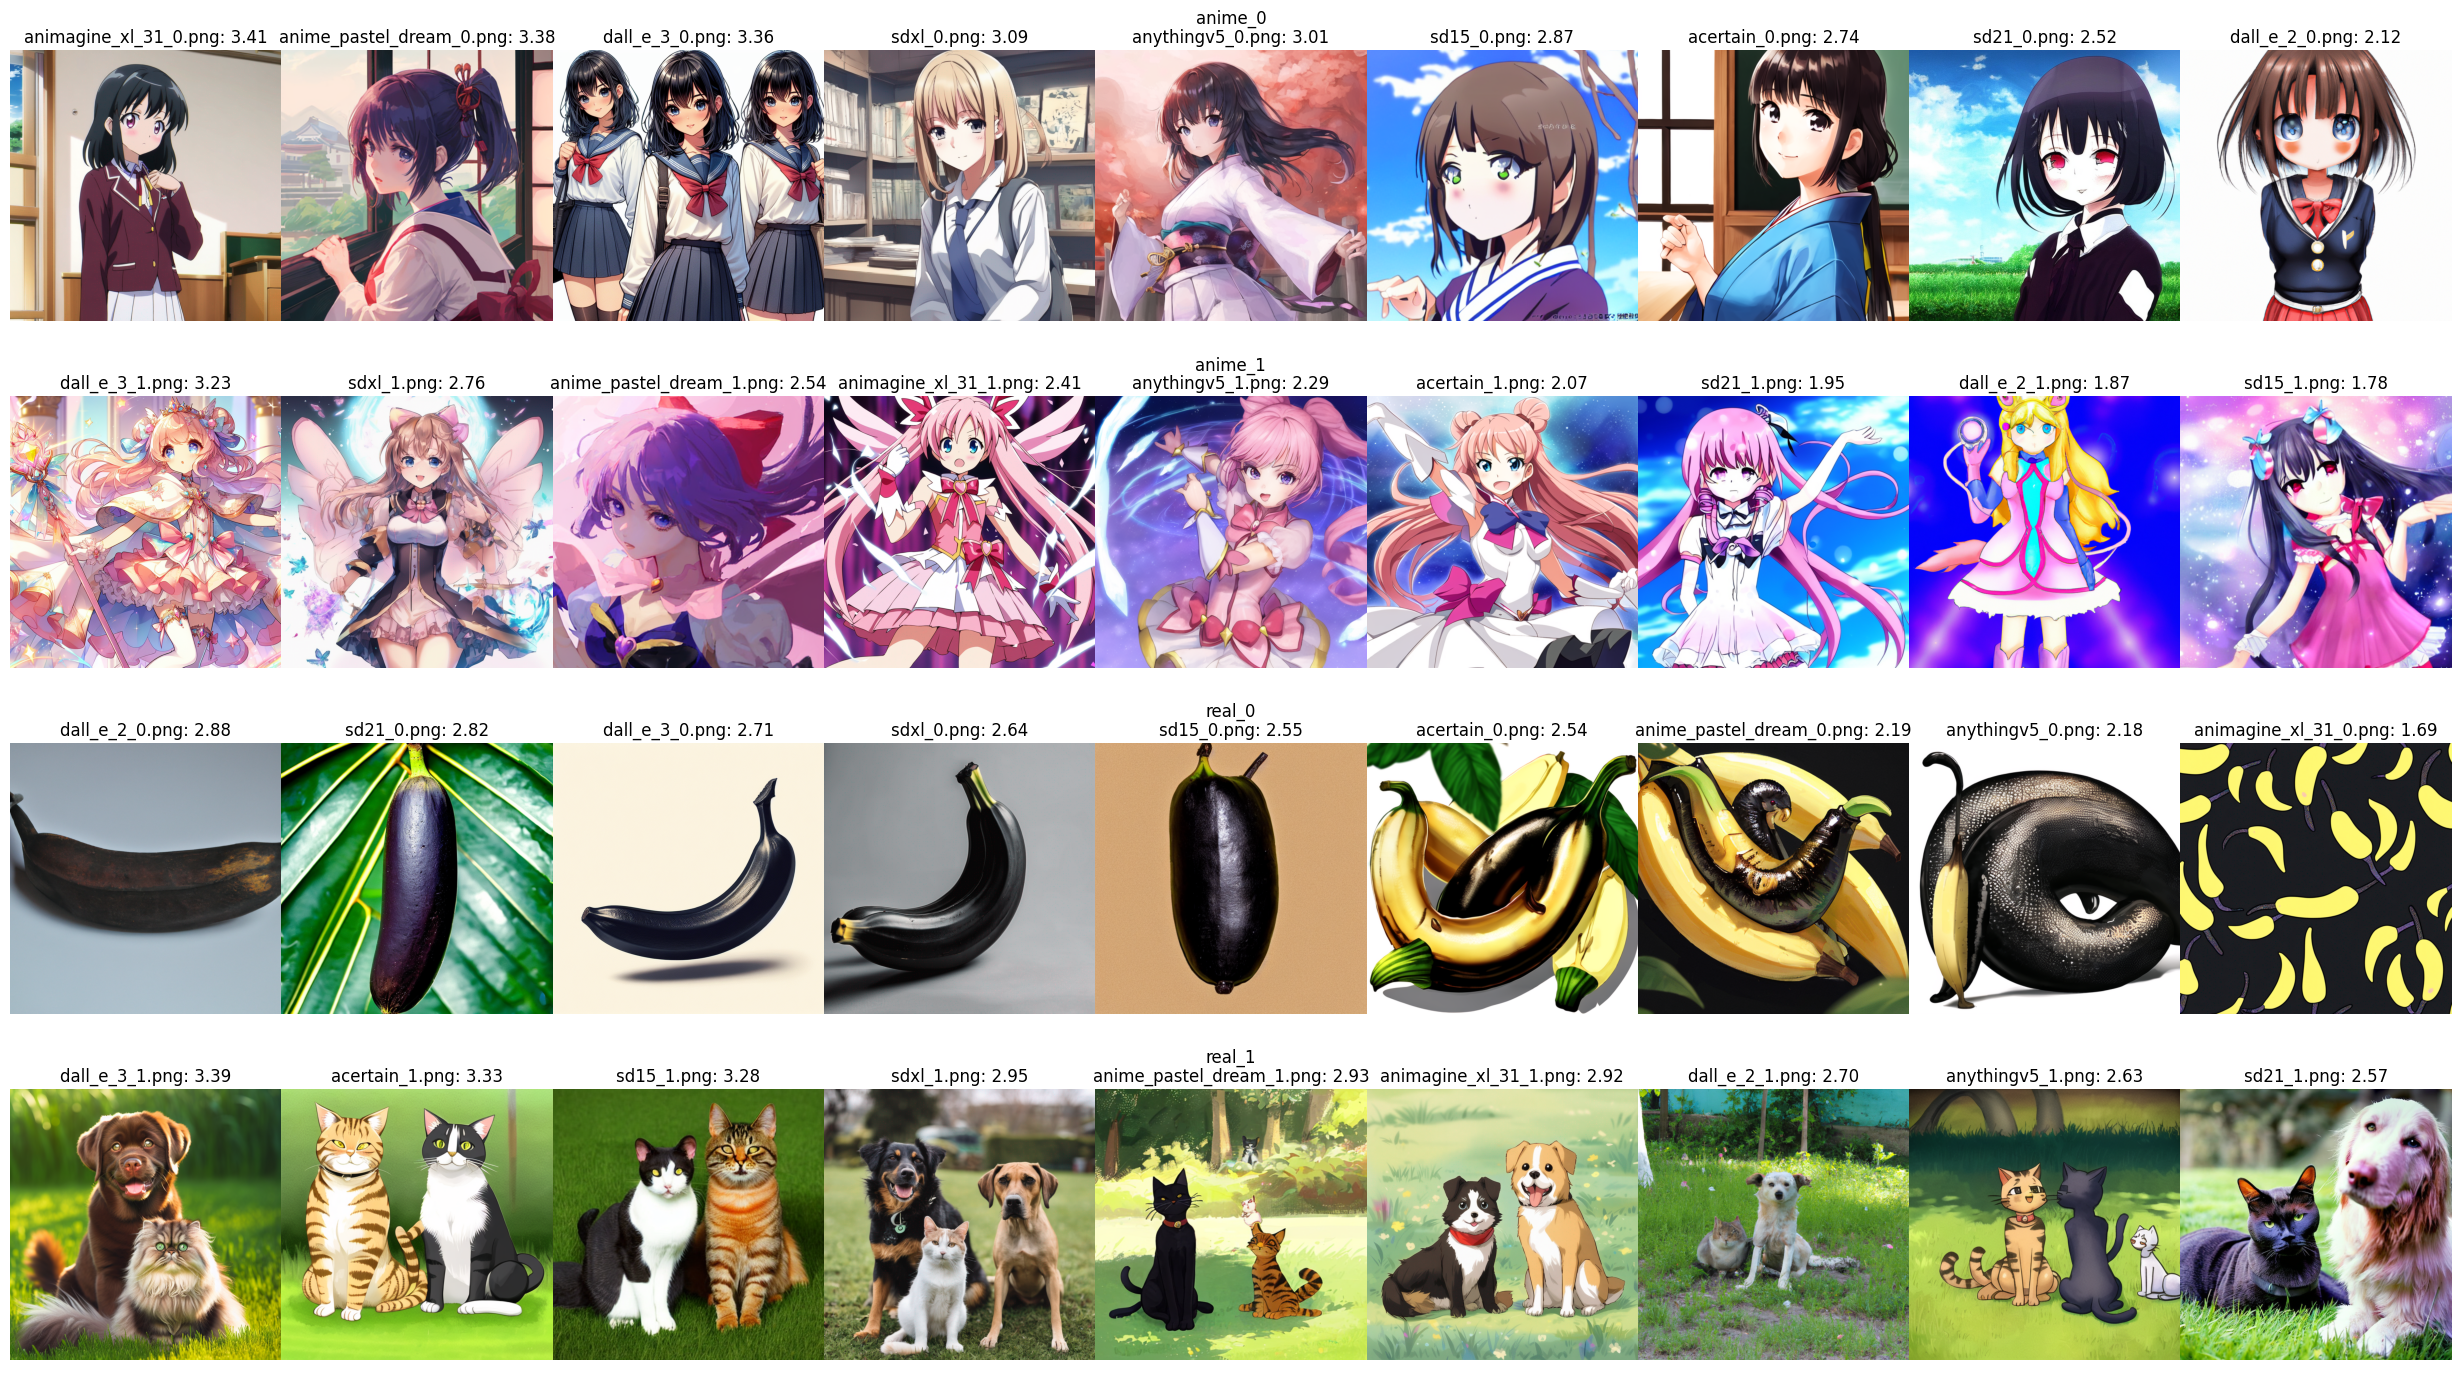

In [32]:
prompts = {
    "anime" : [
        "1girl, japanese school anime, girl, solo, best quality",
        "1girl, magical girl, anime, solo, best quality"
    ],
    "real" : [
        "A black colored banana.",
        "One cat and one dog sitting on the grass."
    ]
}

score_data = {}
image_root_dir = "aesthetics_toy_images"
subdirs = sorted(glob.glob(f"{image_root_dir}/*"))
for subdir in subdirs:
    for i in range(2):
        subdir_key = f"{os.path.basename(subdir)}_{i}"
        print(subdir_key)
        files = sorted(glob.glob(subdir+f"/*{i}.png"))
        score_data[subdir_key] = {}
        for file in files:
            output_value = inference_model.predict(prompts[os.path.basename(subdir)][i], file)
            score_data[subdir_key][os.path.basename(file)] = output_value
            print(f'{os.path.basename(file)}: {output_value}')
        print()

# Plot
fig, axes = plt.subplots(len(score_data), 1, figsize=(25, 3.5 * len(score_data)))

# 各ケースごとにスコアを降順ソートして画像を表示
for i, (case, scores) in enumerate(score_data.items()):
    sorted_scores = sorted(scores.items(), key=lambda item: item[1][0, 0], reverse=True)
    images = [Image.open(os.path.join(image_root_dir, case.split("_")[0], img)) for img, score in sorted_scores]
    filenames = [img for img, score in sorted_scores]
    scores = [score[0, 0] for img, score in sorted_scores]
    
    ax = axes[i] if len(score_data) > 1 else axes
    for j, (image, filename, score) in enumerate(zip(images, filenames, scores)):
        ax_sub = ax.inset_axes([j/len(images), 0, 1/len(images), 1], transform=ax.transAxes)
        ax_sub.imshow(image)
        ax_sub.set_title(f'{filename}: {score:.2f}')
        ax_sub.axis('off')
    ax.set_title(case)
    ax.axis('off')

plt.tight_layout()
plt.savefig("agiqa_3k_custom_predictor.png")
plt.show()    